In [17]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score
import keras as k
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
subsets = {
    1: [1, 7, 8, 9, 36, 37],
    2: [2, 5, 10, 11, 12, 13, 15, 39, 40, 41, 42, 44, 38, 65],
    3: [3, 6, 14, 16, 17, 19, 20, 43, 45, 46, 48, 49],
    4: [18, 21, 22, 23, 24, 25, 26, 47, 50, 51, 52, 53, 54, 55],
    5: [4, 27, 28, 29, 30, 31, 32, 33, 34, 35, 56, 57, 58, 59, 60, 61, 62, 63, 64],
}

label = "0"
train_df = pd.DataFrame(columns=['path', 'label'])
for i in subsets[2]:
    new_df = pd.DataFrame({'path': ['YaleB/B01P00/' + str(i) + '.tif'], 'label': [label]})
    train_df = pd.concat([train_df, new_df], ignore_index=True)

label = "1"
for i in subsets[2]:
    new_df = pd.DataFrame({'path': ['YaleB/B02P00/' + str(i) + '.tif'], 'label': [label]})
    train_df = pd.concat([train_df, new_df], ignore_index=True)



label = "0"
test_df = pd.DataFrame(columns=['path', 'label'])
for i in subsets[1] + subsets[3] + subsets[4] + subsets[5]:
    new_df = pd.DataFrame({'path': ['YaleB/B01P00/' + str(i) + '.tif'], 'label': [label]})
    test_df = pd.concat([test_df, new_df], ignore_index=True)

label = "1"
for i in subsets[1] + subsets[3] + subsets[4] + subsets[5]:
    new_df = pd.DataFrame({'path': ['YaleB/B01P00/' + str(i) + '.tif'], 'label': [label]})
    test_df = pd.concat([test_df, new_df], ignore_index=True)

In [19]:
train_datagen = ImageDataGenerator(shear_range=0.2, vertical_flip=True)

training_set = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='./',
    x_col="path",
    y_col="label",
    target_size=(160, 160),
    batch_size=8,
    class_mode='binary')

test_datagen = ImageDataGenerator()

test_set = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='./',
    x_col="path",
    y_col="label",
    target_size=(160, 160),
    batch_size=8,
    class_mode='binary')

Found 28 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


In [40]:
cnn = k.models.Sequential()

cnn.add(k.layers.Conv2D(filters=16, kernel_size=3, input_shape=[160, 160, 3]))
cnn.add(k.layers.BatchNormalization())
cnn.add(k.layers.Activation("relu"))
cnn.add(k.layers.MaxPool2D(pool_size=4, strides=4))

cnn.add(k.layers.Conv2D(filters=32, kernel_size=3))
cnn.add(k.layers.BatchNormalization())
cnn.add(k.layers.Activation("relu"))
cnn.add(k.layers.BatchNormalization())

cnn.add(k.layers.Conv2D(filters=64, kernel_size=3))
cnn.add(k.layers.BatchNormalization())
cnn.add(k.layers.Activation("relu"))
cnn.add(k.layers.AveragePooling2D(pool_size=2, strides=2))

cnn.add(k.layers.Flatten())

cnn.add(k.layers.Dense(units=256, activation="relu"))
cnn.add(k.layers.Dense(units=148))
cnn.add(k.layers.Dense(units=1, activation="sigmoid"))

cnn.compile(
    optimizer=k.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [41]:
# train
history = cnn.fit(x=training_set, validation_data=test_set, epochs=100, batch_size=8)


Epoch 1/100
4/4 [==============================] - 3s 312ms/step - loss: 17.5045 - accuracy: 0.5357 - val_loss: 29.4698 - val_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 1s 237ms/step - loss: 2.7463 - accuracy: 0.6786 - val_loss: 3.4685 - val_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 1s 232ms/step - loss: 1.6204 - accuracy: 0.5357 - val_loss: 3.3367 - val_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 1s 241ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 9.4624 - val_accuracy: 0.5000
Epoch 5/100
4/4 [==============================] - 1s 232ms/step - loss: 0.6298 - accuracy: 0.8214 - val_loss: 8.1433 - val_accuracy: 0.5000
Epoch 6/100
4/4 [==============================] - 1s 229ms/step - loss: 0.2030 - accuracy: 0.9643 - val_loss: 4.5811 - val_accuracy: 0.5000
Epoch 7/100
4/4 [==============================] - 1s 232ms/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 2.9091 - val_accuracy: 0.5000
Epoch 8/100

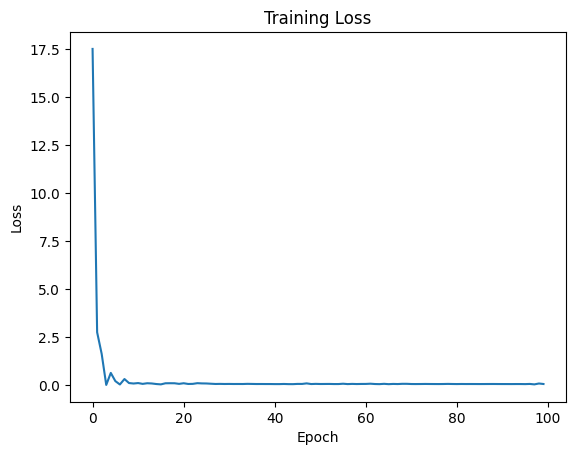

In [42]:
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(history.history["loss"])
plt.show()

In [30]:
# f1 and accuracy
y_pred = cnn.predict(test_set)
y_pred = (y_pred > 0.5)
y_true = test_set.classes
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("F1: ", f1_score(y_true, y_pred))


13/13 [==============================] - 0s 25ms/step
Accuracy:  0.4803921568627451
F1:  0.18461538461538463


In [39]:
# test on one image
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('YaleB/B01P00/1.tif', target_size=(160, 160))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = cnn.predict(test_image)
if result[0][0] == 1:
    prediction = '1'
else:
    prediction = '0'
print(prediction)

# another image test
test_image = image.load_img('YaleB/B02P00/1.tif', target_size=(160, 160))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = cnn.predict(test_image)
if result[0][0] == 1:
    prediction = '1'
else:
    prediction = '0'
print(prediction)



1/1 [==============================] - 0s 28ms/step
0
1/1 [==============================] - 0s 27ms/step
0
